In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from ipywidgets import widgets, interact

import UsefulUtils as uu
uu.init_notebook(dpi=120, fontsize=10)

from UsefulUtils import Bunch
import ScopeFoundry as sf

from PicoharpPTU import PicoHarpPTU
from picoharpdata import PicoHarpData

import glob

In [2]:
def make_histogram(filename, binCount, USE_PTU=False):
    #Use Ed's software to load the file
    if USE_PTU:
        PHD = PicoHarpPTU(filename, True)
    else:
        PHD = PicoHarpData(filename, True)

    # Find all of the record indices of channel 0 events.  These mark the laser sync signal.
    print 'Finding channel 0 events'
    c0events = np.where(PHD.t2_channels == 0)[0]

    #Compute the time differences between the channel 0 events.  Should be a regular interval.
    print 'Calculating time difference between channel 1 events'
    c0diffs = PHD.t2_times[c0events[1:]] - PHD.t2_times[c0events[:-1]]

    #Construct an empty histogram in which to bin the events.
    timeSpan = np.average(c0diffs)
    hist,bins = np.histogram(np.empty(0, np.int64), bins=binCount, range=[ 0, timeSpan ] )

    #For each channel 0 event, histogram the number of channel 1 events with respect to the delay after
    #the channel 0 event.
    for start,stop in np.nditer([c0events[:-1],c0events[1:]]):
        # Get the events for this excitation pulse
        c1events = np.where(PHD.t2_channels[start:stop] == 1)[0] + start

        # Histogram the times of the fluorescence events with respect to the excitation pulse
        hist = hist + (
          np.histogram(PHD.t2_times[c1events]-PHD.t2_times[start], bins=binCount, range=(0, timeSpan) ) 
          )[0]
    
    return bins[:-1]*4*10**-6, hist


In [3]:
background_file = ""
signal_file = "Er-enhanced-t2-100s-6mW-1.pt2"

if signal_file == "":
    files = glob.glob("./*.pt2")
    files.sort()
    signal_file = files[-1]    

In [ ]:

signal = Bunch()
bins, ints = make_histogram(signal_file, 1000)
signal.time= bins
signal.intensity = ints

bg = Bunch()
if background_file == "":
    bg.time = signal.time.copy()
    bg.intensity = np.zeros(signal.intensity.shape)
else:
    bins, ints = make_histogram(background_file, 1000)
    bg.time = bins
    bg.intensity = ints


ident:  'PicoHarp 300'
format_version: '2.0'
V1 False V2 True
'PicoHarp Software'
'2.3.0.0'
file_time:  '18/10/17 16:57:47'
comment : 'T2 Mode'
binaryfile_header:  (0, 32, 1, 1, 0, 2, 0, 7, 0, 100000, 100, 0, 1, 1, 0, 12000, 0, 100)
number_of_curves 0
number_of_boards 1
array([0, 1, 2, 3, 4, 5, 6, 7])
array([ True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)
board 0
board 0 resolution 0.512000024319
T2 records read 23601396
T2 records convert to numpy
{'V1': False,
 'V2': True,
 'active_curve': 0,
 'bits_per_histo_bin': 32,
 'boards': [PicoHarpBoard{'RtChan3_InputEdge': 0, 'RtChan2_CFDZeroCross': 0, 'sync_divider': 1, 'RtChan4_InputEdge': 0, 'RtChan4_CFDPresent': 0, 'RtChan4_InputLevel': 0, 'RtChan2_InputType': 0, 'cfd_level_1': 61, 'RtChan1_CFDLevel': 0, 'cfd_level_0': 91, 'RtChan1_CFDZeroCross': 0, 'RtChan4_CFDLevel': 0, 'RtChan3_CFDLevel': 0, 'cfd_zero_cross_0': 0, 'cfd_zero_cross_1': 0, 'RtChan2_InputEdge': 0, 'RtChan1_CFDPresent': 0, 'RtChan3_CFDPresent': 0, 'RtC

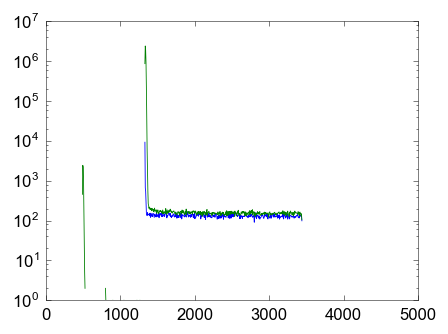

In [16]:
plt.semilogy(bg.time, bg.intensity)
plt.semilogy(signal.time, signal.intensity)

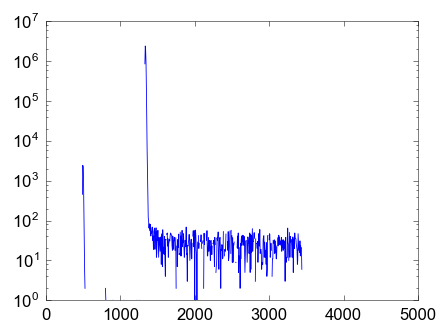

In [17]:
plt.semilogy(signal.time, signal.intensity - bg.intensity)